In [ ]:
%load_ext autoreload
%autoreload 2

# Training

> The `training.core` module contains the core bits required to train text/NLP models with fast.ai. This includs custom parameter group splitters, callbacks, show methods and basic inference capabilities

In [ ]:
# |default_exp training.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import PreTrainedModel, logging as hf_logging

from blurr.data.core import TextInput, first_blurr_tfm
from blurr.utils import PreCalculatedLoss

In [ ]:
# |hide
import pdb, nbdev

from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.data.transforms import DataLoader, DataLoaders, Datasets
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.text.data import SortedDL
from fastcore.test import *
from transformers import AutoModelForSequenceClassification

from blurr.utils import *
from blurr.data.core import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Hot Millions is a great movie in every way. A fun, offbeat story with wonderful performances by four of the best professionals ever to work in the business. Peter Ustinov is brilliant, as usual, and Maggie Smith---definitely one of the greatest actresses of all time--- is a total delight. Karl Malden and Bob Newhart round out the cast and are also perfect. If you want a movie that has perfect casting, this is it. What is so impressive is the way these people work off each other in such a natural and effortless way, creating lots of laughs and fun moments throughout. Peter Ustinov was a gen...",1,False
1,"This movie has everything a fantasy movie should have, romance, clever witticisms, great acting and a fair dose of magic. <br /><br />I thoroughly enjoyed this movie and was drawn to its original plot (based on the Neil Gaiman novel which I am now looking to read) and colorful characters.<br /><br />One of the most striking things to me actually was how self contained the story is. Unlike so many sci-fi fantasy movies out there right now which leave open-endings and such this was a pure fairy-tale, satisfying in and of itself with no need for a sequel.<br /><br />Original. Fun. Feel-good F...",1,False
2,"Even with a cast that boasts such generally reliable names as Val Kilmer and Lisa Kudrow, Wonderland fails to yield any sense of depth to this film. It barely brushes the surface of the incidents that happened on that July night in 1981. Kilmer just goes through the motions as John Holmes and Kudrow and Kate Bosworth are both hopefully miscast in the other two lead roles; as Holmes's wife and underage girlfriend, respectively. The rest of the cast has such small roles that it's impossible to get any dimensions from them. The film also stars Carrie Fisher, Ted Levine, Franky G, MC Gainey, D...",0,False
3,"I've read reviews that apparently you have to have been a student in a very strict, British school in the 1960's to understand this. Maybe that's true, if so, then this movie is outdated.<br /><br />*************SPOILER ALERT**************************************** The ending makes about as much sense as all the kids who're anti-government and anti-corporation without having any better solution that doesn't torch society to a Mad Max type cinder.<br /><br />Yeah, the main characters could leave, but they don't. The reasons they go about this don't make sense. There isn't enough character d...",0,False
4,"This tiresome, plodding Las Vegas casino heist movie in almost impossible to watch and get involved in. It's something you 'look at' if you have absolutely nothing else better to do. The only two decent things in this movie are both attached to gorgeous Stella Stevens and one spends the entire program hoping she'll fall out of one of those skimpy tops she wears. Many great shots of mid-70s Las Vegas (when it was still a cool place to visit) and the fashions of the day are good for a giggle as well. Otherwise, one big yawn. The Rhino dvd has a very good widescreen transfer but even at under...",0,False


In [ ]:
label_names = imdb_dsd[0].features["label"].names
label_names

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_label_names = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_label_names:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_label_names:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,"If the initiative passes, would crooks like the ""Alaska Bush People"" from Texas who sign up to get the dividend money be able to vote in Alaska elections? What happens if they had voted and are later found out to have been ineligible to claim a dividend for years? https://www.adn.com/crime-justice/article/stars-alaskan-bush-people-charged-theft-pfd-fraud/2014/10/23/",0,0,0,0,0,0,0,False
1,"blah, blah, blah. Hopefully no else turns them in. Every one will think you did it and lose all respect and trust in you! Wait a minute..... no one had any respect and trust you in the first place! Never mind!",0,0,0,0,0,0,0,False
2,All is well according to Martin Regg Cohn. Read ''on the ropes'' if you want to raise your blood pressure,0,0,0,0,0,0,0,False
3,It's kind of hard to trust the ones who have been ripping you off for decades. Kinda like trusting a drug addict after he/she has ripped you off multiple times but promises you that they will quit if you will fund one more hit.,0,0,0,0,0,0,0,False
4,"Same boilerplate, different day.\nYou not only know where they live but what they think. Because they trust you and confide in you, too.\nHeartfelt condolences to those trapped in your orbit.",0,0,0,0,0,0,0,False


## Base API

Base splitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L34){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L41){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L53){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s (PyTorch)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multiclass_tokenize_func, hf_tokenizer=hf_tokenizer)
proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.010964781977236271, valley=5.248074739938602e-05, slide=0.0012022644514217973)

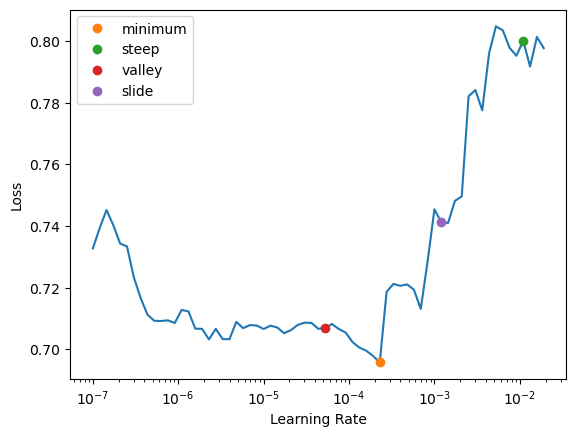

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.17747728526592255
valid_loss 0.1722780019044876
accuracy 0.9449999928474426


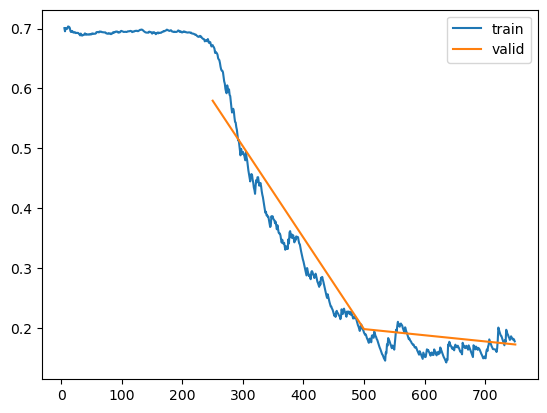

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s (PyTorch)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multilabel_tokenize_func, hf_tokenizer=hf_tokenizer, label_attrs=civil_label_names)
proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        # item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=0.015848932787775993, valley=0.00010964782268274575, slide=0.0003981071640737355)

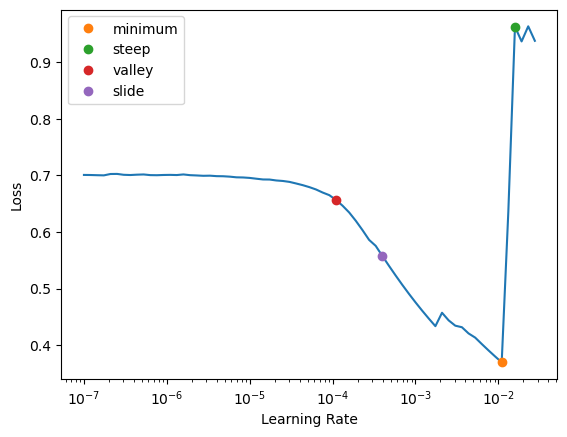

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07094478607177734
valid_loss 0.07023784518241882
accuracy_multi 0.9842856526374817


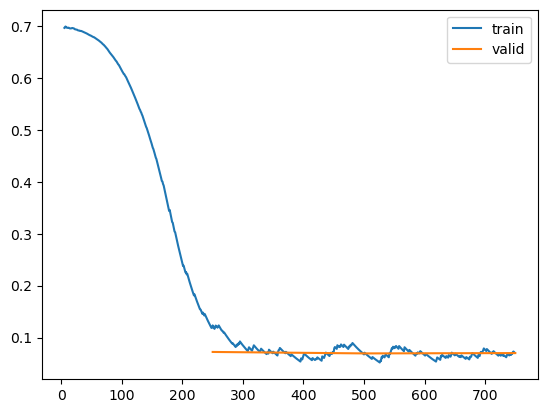

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets` (huggingface)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multiclass_tokenize_func, hf_tokenizer=hf_tokenizer)
proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d8fa40af216b26ca.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.0063095735386013985, valley=7.585775892948732e-05, slide=0.0005754399462603033)

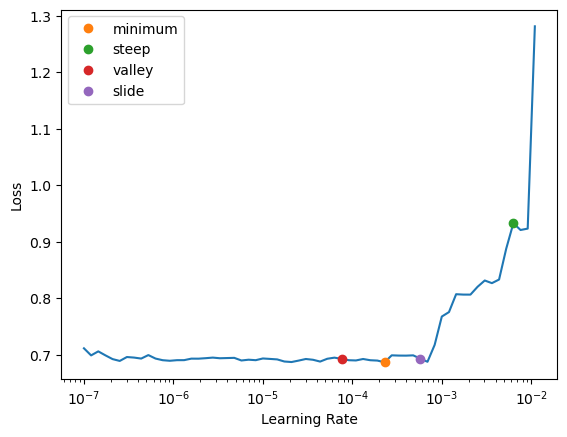

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.188323974609375
valid_loss 0.1795760691165924
accuracy 0.9399999976158142


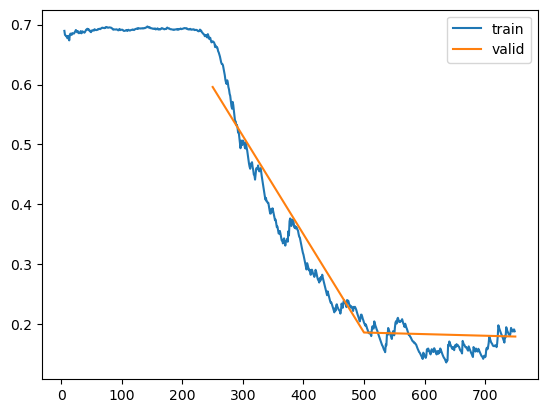

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets` (huggingface)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multilabel_tokenize_func, hf_tokenizer=hf_tokenizer, label_attrs=civil_label_names)
proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-7ca939fe295897d3.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=0.015848932787775993, valley=0.00010964782268274575, slide=0.0003981071640737355)

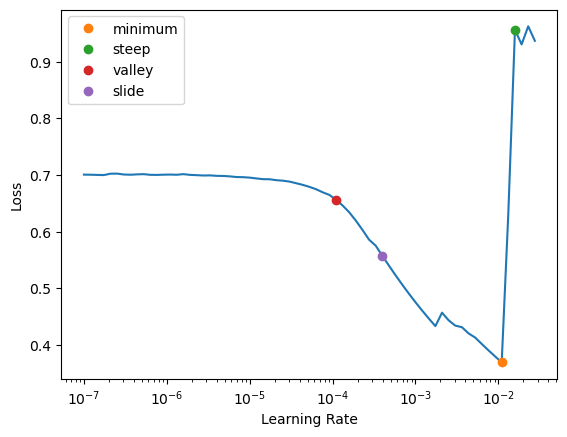

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07095006108283997
valid_loss 0.0702379047870636
accuracy_multi 0.9842856526374817


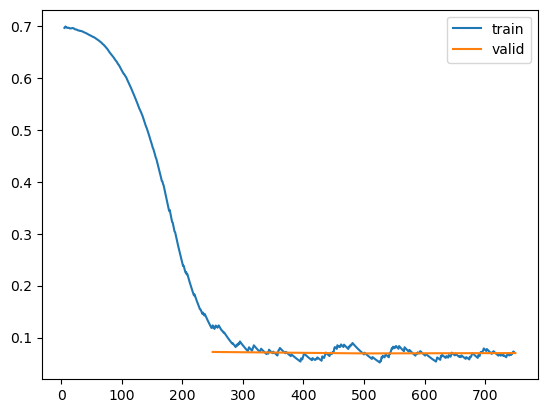

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

Most of the work to get things compliant with fast.ai's low-level API is already handed in the `data.core` module. In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_label_names = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_label_names is None and learner.dls.vocab is not None:
        trg_label_names = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        pred = outs[idx]

        # add in the input text
        input_ids = x[idx]
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]

        # add in the targets
        sample = samples[idx] if samples is not None else None
        for item_idx, item in enumerate(sample[n_inp:]):
            label = y[item_idx] if y is not None else item

            if torch.is_tensor(label):
                label = list(label.numpy()) if len(label.size()) > 0 else label.item()

            if is_listy(label):
                trg = [trg_label_names[int(idx)] for idx, val in enumerate(label) if (val == 1)] if trg_label_names else label
            else:
                trg = trg_label_names[int(item)] if trg_label_names else item

            rets.append(trg)

        # add in the predictions
        for item in pred:
            if torch.is_tensor(item):
                item = list(item.numpy()) if len(item.size()) > 0 else item.item()

            if is_listy(item):
                p = [trg_label_names[int(idx)] for idx, val in enumerate(item) if (val == 1)] if trg_label_names else item
            else:
                p = trg_label_names[int(item)] if trg_label_names else item

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Multiclass

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multiclass_tokenize_func, hf_tokenizer=hf_tokenizer)
proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

#### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(hf_tokenizer, hf_arch, hf_config, hf_model, label_names=label_names)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8, trunc_at=500)

,text,target
0,"Hot Millions is a great movie in every way. A fun, offbeat story with wonderful performances by four of the best professionals ever to work in the business. Peter Ustinov is brilliant, as usual, and Maggie Smith---definitely one of the greatest actresses of all time--- is a total delight. Karl Malden and Bob Newhart round out the cast and are also perfect. If you want a movie that has perfect casting, this is it. What is so impressive is the way these people work off each other in such a natural",pos
1,"This review also contains a spoiler of the first movie -- so if you haven't seen either movie and want to but don't want the spoilers, please don't read this review!<br /><br />While this movie is supposed to be about Christian and Kathryn meeting for the first time, the movie is a poor copy of the first Cruel Intentions. The actors that they had portray Ryan Phillippe's Christian and Sarah Michelle Gellar's Kathryn are very poor substitutes indeed. Neither can pull off the smarmy, snooty rich-k",neg
2,"When the scientist and family man Matt Winslow (Robert Urich) finally accepts the invitation to work the Micro-Digitech Corporation in a space suit project, he moves with his beloved wife Patricia (Joanna Cassidy) and their son Robbie (Barret Oliver) and daughter Chrissy (Soleil Moon Frye) to a huge modern house in the corporation compound. They meet their friend Tom Peterson (Joe Regalbuto) and his family completely adapted to the new lifestyle, and Tom invites the Winslow family to join the St",pos
3,"When I saw previews of this movie I thought that it may be dumb, but it will at least be funny. Well I was wrong. Even though somewhere deep down the producers had an interesting message to convey about parents being left alone and re-evaluating their life, the way they tried to deliver that message was horrible. The first fifty times something silly happened to the couple was relatively funny. But by the end, I could almost predict what stupid mishap is going to happen next.<br /><br />Througho",neg


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

#### Step 5: Train

SuggestedLRs(minimum=1.58489319801447e-07, steep=0.0030199517495930195, valley=9.999999747378752e-06, slide=7.585775892948732e-05)

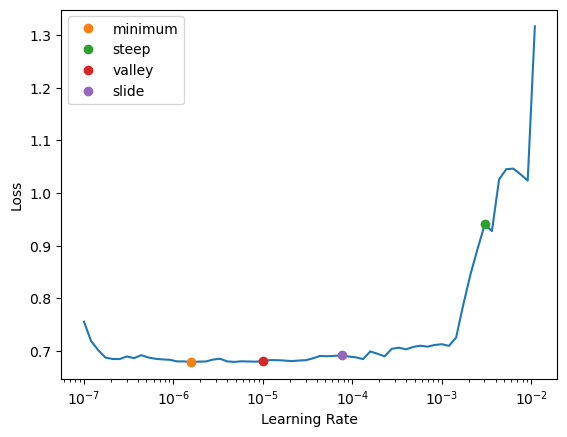

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19426560401916504
valid_loss 0.17506632208824158
accuracy 0.9399999976158142


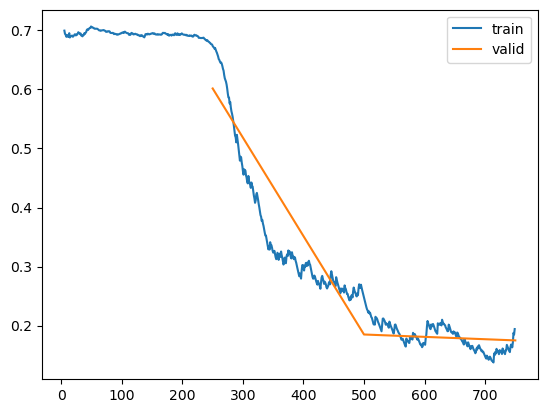

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"This is a great film in many different ways...perhaps the most important is that it introduces Western audiences to the remarkable, tragic story of Aung San Suu Kyi and her fight for freedom and democracy. Wonderful acting, gorgeous cinematography, breathtaking action and suspense: ""Beyond Rangoon"" has everything. I've seen this movie several times over the last ten years and each time it means more to me. Not everyone will like it (hence the relatively low rating on IMDb), but that's because it",pos,pos
1,"As we are well aware, movies are not set out to be a direct incorporation of history, but it is a disgrace when a movie is made which has absolutely little to no correlation. I wish the director and/or the screen writer had done his/her research in this topic. All this movie does is create a forum for hate between people, while causing a rift that should not be there. This movie portrayed the Sikhs and Muslims in a very negative manor, while making the third group (Hindus) look as if they were n",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Multilabel

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# tokenize the dataset
tokenize_func = partial(multilabel_tokenize_func, hf_tokenizer=hf_tokenizer, label_attrs=civil_label_names)
proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

#### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(hf_tokenizer, hf_arch, hf_config, hf_model, label_names=civil_label_names)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"If the initiative passes, would crooks like the ""Alaska Bush People"" from Texas who sign up to get the dividend money be able to vote in Alaska elections? What happens if they had voted and are later found out to have been ineligible to claim a dividend for years? https://www.adn.com/crime-justice/article/stars-alaskan-bush-people-charged-theft-pfd-fraud/2014/10/23/",[]
1,"Calm down. You keep telling me what I need for a comfortable life, but you have yet to say why you should have any imput. You go on to entirely miss the point wrt large estates. Small surprise. Time to put your thinking cap on.",[]
2,nice,[]
3,"When you rhetorically describe people with whom you disagree as ""haters,"" aren't you doing some ""spewing"" yourself? Can't you read? Police records show Hodgkinson went to a neighbor’s house looking for his teenage girl, forced his way inside, damaged a door, grabbed her by the hair when he found her upstairs. She escaped and got into the neighbor’s car. He opened the door, pulled out a pocket knife and cut off the seat belt she was wearing. His wife joined him, struggling to pull out their daughter, as he punched the woman neighbor who was in the driver’s seat of the car in the face, witnesses told police. The woman's boyfriend, went to his home to confront him. He said Hodgkinson “walked outside with a shotgun and aimed it at Fernandez face,” struck him on the side of his face with the wooden shotgun stock and fired off one round as he ran away. The pair were charged with domestic battery and aggravated discharge of a firearm, charges later dismissed. He killed the neighbor's dog.",[]


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 377)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 377 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 377 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.0009120108559727668, steep=0.0003311311302240938, valley=0.00013182566908653826, slide=0.005248074419796467)

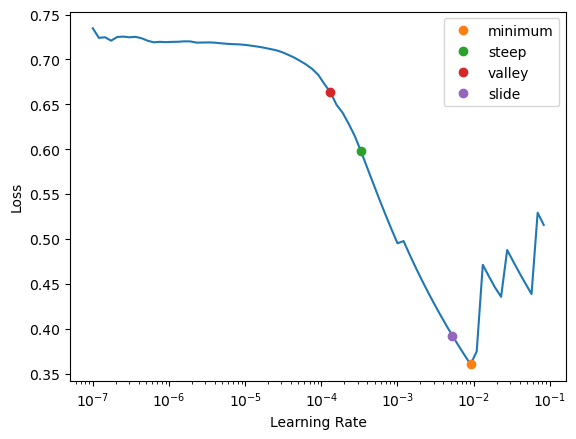

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07446497678756714
valid_loss 0.0703330785036087
accuracy_multi 0.9842856526374817


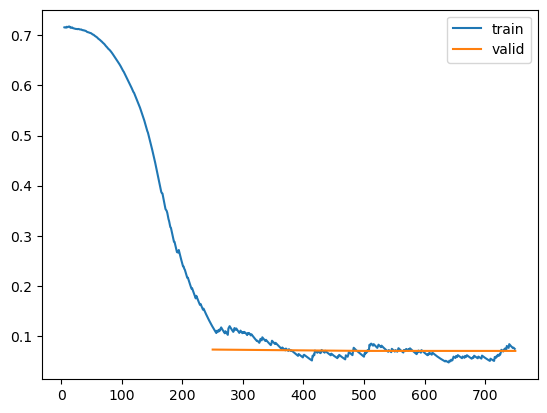

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"I am a humanitarian.. and without question a global supporter for the rights of Women and Children. In this regard, my initial response was; I am grateful that Canada was willing to help the millions of women in the USA.. who, without question, are being punitively treated, by their Government. Equally, on the other side, I do not want our Canadian Government to EVER, lose sight, of the VERI NECESSARY NEEDS, of Canadian Women, with respect, to effective, resource filled, women centers, and sexua",[],[]
1,"It appears that more NFL players are choosing to exhibit the ""Black Power"" salute. In the 1968 Summer Olympics, Americans Juan Carlos and Tommy Smith both raised the ""Black Power"" salute on the winners podium. The IOC stripped both of their medals and banned them from Olympic competition for life. The NFL players ""Black Power"" salute reflects what the African-American players fundamentally believe and espouse. However, DP and the Kiz both lack the moral ability to address what ""Black Power"" clea",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"label_names": label_names}
)

blocks = (txt_block, CategoryBlock)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
tokenize_func = partial(multiclass_tokenize_func, hf_tokenizer=hf_tokenizer)
proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

# build your `DataLoaders`
dls = dblock.dataloaders(proc_imdb_ds, bs=4)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-40c988ff5f6142a6.arrow


In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"Hot Millions is a great movie in every way. A fun, offbeat story with wonderful performances by four of the best professionals ever to work in the business. Peter Ustinov is brilliant, as usual, and Maggie Smith---definitely one of the greatest actre",pos
1,"I shouldn't even review this movie, since it's not actually a horror movie -- and thus not worthy of Dr. Cheese's attention. At least, it's not horror in the usual sense. It's certainly a horrifying proposition to waste your time watching this crap.",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.0964781722577755e-07, steep=0.009120108559727669, valley=9.999999747378752e-06, slide=0.0003981071640737355)

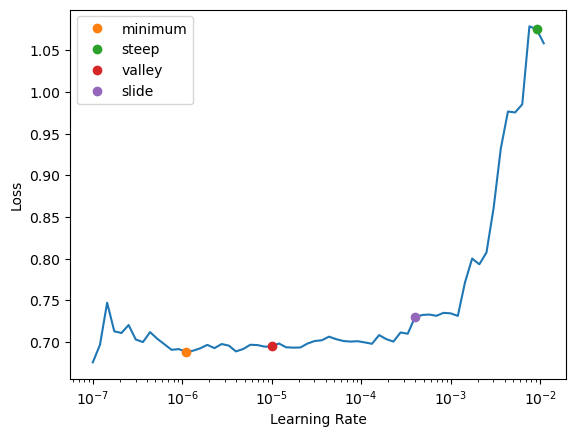

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.183281809091568
valid_loss 0.1791120320558548
accuracy 0.9350000023841858


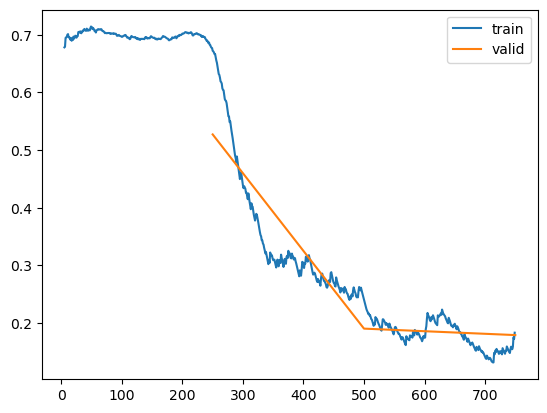

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"This is a great film in many different ways...perhaps the most important is that it introduces Western audiences to the remarkable, tragic story of Aung San Suu Kyi and her fight for freedom and democracy. Wonderful acting, gorgeous cinematography, breathtaking action and suspense: ""Beyond Rangoon"" has everything. I've seen this movie several times over the last ten years and each time it means more to me. Not everyone will like it (hence the relatively low rating on IMDb), but that's because it",pos,pos
1,"As we are well aware, movies are not set out to be a direct incorporation of history, but it is a disgrace when a movie is made which has absolutely little to no correlation. I wish the director and/or the screen writer had done his/her research in this topic. All this movie does is create a forum for hate between people, while causing a rift that should not be there. This movie portrayed the Sikhs and Muslims in a very negative manor, while making the third group (Hindus) look as if they were n",neg,neg


In [ ]:
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model)

blocks = (txt_block, MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
tokenize_func = partial(multilabel_tokenize_func, hf_tokenizer=hf_tokenizer, label_attrs=civil_label_names)
proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

dls = dblock.dataloaders(proc_civil_ds, bs=4)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-64688c78d88a5b17.arrow


In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"If the initiative passes, would crooks like the ""Alaska Bush People"" from Texas who sign up to get the dividend money be able to vote in Alaska elections? What happens if they had voted and are later found out to have been ineligible to claim a dividend for years? https://www.adn.com/crime-justice/article/stars-alaskan-bush-people-charged-theft-pfd-fraud/2014/10/23/",[]
1,"Calm down. You keep telling me what I need for a comfortable life, but you have yet to say why you should have any imput. You go on to entirely miss the point wrt large estates. Small surprise. Time to put your thinking cap on.",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 377)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 377 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 377 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0009120108559727668, steep=0.0003311311302240938, valley=0.00013182566908653826, slide=0.0003311311302240938)

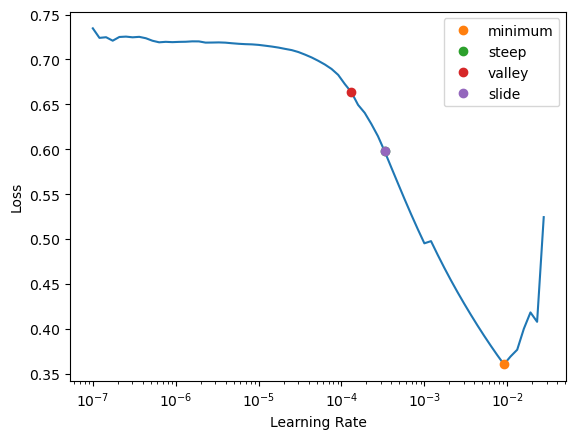

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07499276101589203
valid_loss 0.07085884362459183
accuracy_multi 0.9842856526374817


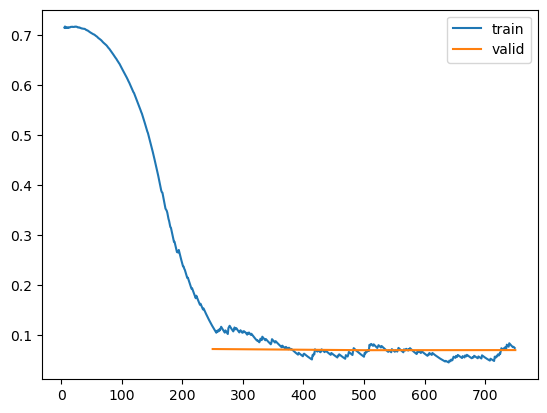

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"I am a humanitarian.. and without question a global supporter for the rights of Women and Children. In this regard, my initial response was; I am grateful that Canada was willing to help the millions of women in the USA.. who, without question, are being punitively treated, by their Government. Equally, on the other side, I do not want our Canadian Government to EVER, lose sight, of the VERI NECESSARY NEEDS, of Canadian Women, with respect, to effective, resource filled, women centers, and sexua",[],[]
1,"It appears that more NFL players are choosing to exhibit the ""Black Power"" salute. In the 1968 Summer Olympics, Americans Juan Carlos and Tommy Smith both raised the ""Black Power"" salute on the winners podium. The IOC stripped both of their medals and banned them from Olympic competition for life. The NFL players ""Black Power"" salute reflects what the African-American players fundamentally believe and espouse. However, DP and the Kiz both lack the moral ability to address what ""Black Power"" clea",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

# note: we pass the label_names here because the labels in the dataset are already encoded as 0 or 1
blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"label_names": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"***SPOILERS*** ***SPOILERS*** Continued...<br /><br />From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retarded accent talking endless garbage, two 'ghosts' that serve no real purpose and have no character what-so-ever and a bunch of henchmen. Someone's told me they're vampires (straight out of Blade 2), but they're so undefined I didn't realise.<br /><br",neg
1,"I'm going to write about this movie and about ""Irreversible"" (the (in)famous scene in it). So you are warned, if you haven't seen the movie yet. This are just my thoughts, why I think the movie fails (in the end - pun intended).<br /><br />Acting wise, Rosario Dawson is really good and almost conveys portraying someone almost a decade younger (a teenager in other words). The villain guy is good, but loses his ""evil"" touch right before the end. If he really never changes, then why would he let a",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.58489319801447e-07, steep=8.31763736641733e-06, valley=7.585775847473997e-07, slide=0.0003311311302240938)

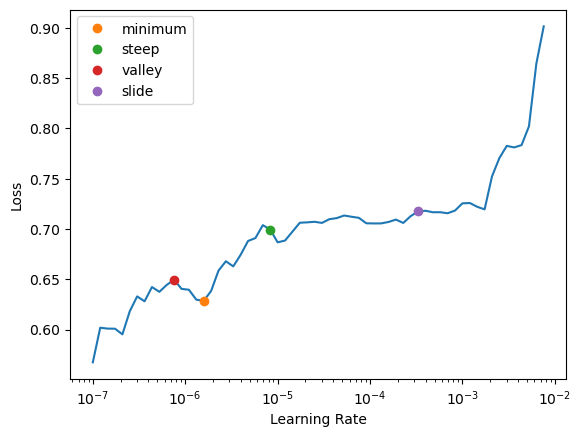

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19451937079429626
valid_loss 0.1905670315027237
accuracy 0.925000011920929


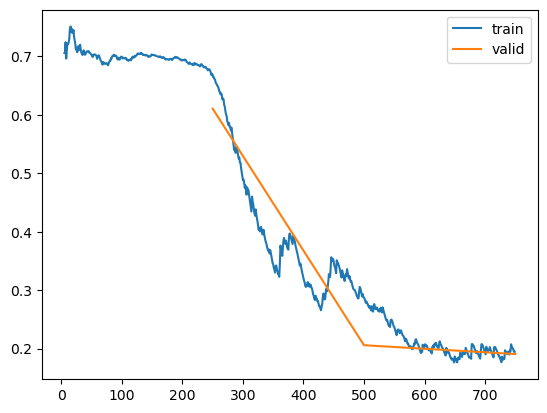

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"(Some spoilers included:)<br /><br />Although, many commentators have called this film surreal, the term fits poorly here. To quote from Encyclopedia Britannica's, surreal means:<br /><br />""Fantastic or incongruous imagery"": One needn't explain to the unimaginative how many ways a plucky ten-year-old boy at large and seeking his fortune in the driver's seat of a red Mustang could be fantastic: those curious might read James Kincaid; but if you asked said lad how he were incongruous behind the w",pos,neg
1,"It is the early morning of our discontent, and some friends of mine and I have just gotten through watching ""The Wind."" Truly a disaster film. Not in the sense of forces of nature wreaking havoc on an unsuspecting populace, but rather an awful movie wreaking havoc on an unsuspecting audience. To give you an indication of how frustrating it was to watch this particular bomb, I'll give you an example quoted during my first pained viewing. If given the choice of watching this movie for a second tim",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_label_names), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,I have just received $16546 This month working online. I am making a good home based income with just my Laptop vand only work for 3 to 4 hours a day. Everybody can Make this part time income from home. Just Visit This link for more info..----->> www.Nypost55.Com,[]
1,"Like this, stevenketola: ""Of course, the teachers are crucial. If they approach Shakespeare as something to be endured rather enjoyed... it's no fun for anyone."" Thank heavens I had teacher Brace Mousette for Grade 10 history/social studies. He was a true polymath guy (once termed ""Renaissance Man"")--most of his time was spent teaching shop courses. After school, he also taught us how to drive in a dual steering-wheel '54 Ford sedan--during which time he rolled his own and smoked 'em! Loved the",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 377)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 377 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 377 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=0.0002754228771664202, valley=9.120108734350652e-05, slide=0.0004786300996784121)

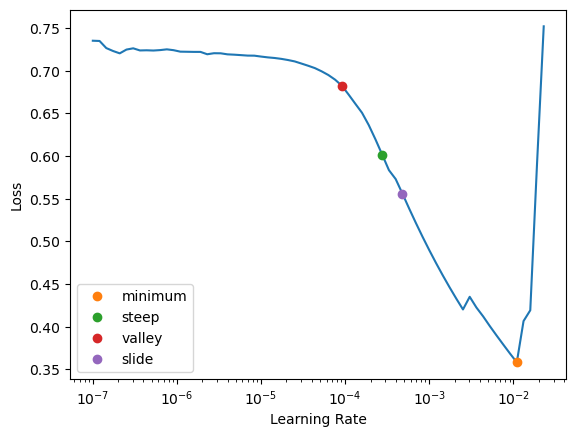

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07234134525060654
valid_loss 0.06935432553291321
accuracy_multi 0.9842856526374817


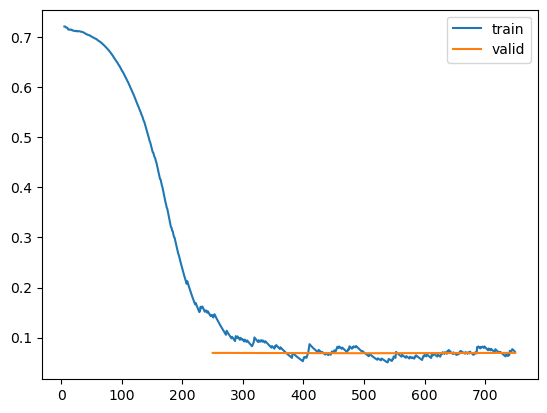

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Loved the article. Has to be used in classrooms when one is trying to explain sarcasm, irony and satire. Then, to the reality of the piece. I don't understand why women do not report rape when it happens, largely because as a male it has not affected me. But I can think of a thousand good reasons to do with fear, stigma, power, humiliation, etc. - all the good things we men have managed to lay on women. Apart from the lies - she really wanted it, NO means OK, etc. We, men, have managed to disemp",[],[]
1,"They are just going to move back or to someone else's neighborhood. FIRST create an approved campsite and trailer parks that allow homeless or homeless with cars to sleep, take public showers with clothes on using open shower heads like at Ala Moana beach park and enough port-a-potties that are regularly cleaned. Hire homeless and pay them a moderate wage like $10 hour to provide security, safety and to keep the area clean and free from drug addicts/trouble makers. Offer counseling service, half",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Item-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        type_tfms=[tfm, tfm2],
        batch_decode_kwargs={"label_names": label_names},
    ),
    CategoryBlock,
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"***SPOILERS*** ***SPOILERS*** Continued...<br /><br />From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retarded accent talking endless garbage, two 'ghosts' that serve no real purpose and have no character what-so-ever and a bunch of henchmen. Someone's told me they're vampires (straight out of Blade 2), but they're so undefined I didn't realise.<br /><br",neg
1,"I'm going to write about this movie and about ""Irreversible"" (the (in)famous scene in it). So you are warned, if you haven't seen the movie yet. This are just my thoughts, why I think the movie fails (in the end - pun intended).<br /><br />Acting wise, Rosario Dawson is really good and almost conveys portraying someone almost a decade younger (a teenager in other words). The villain guy is good, but loses his ""evil"" touch right before the end. If he really never changes, then why would he let a",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=1.58489319801447e-07, steep=8.31763736641733e-06, valley=7.585775847473997e-07, slide=0.0003311311302240938)

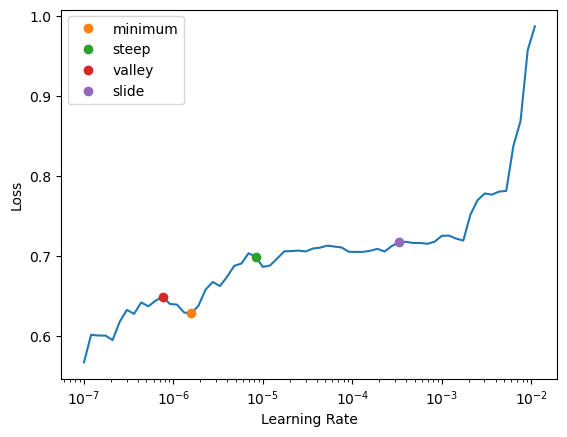

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19102536141872406
valid_loss 0.20126433670520782
accuracy 0.9300000071525574


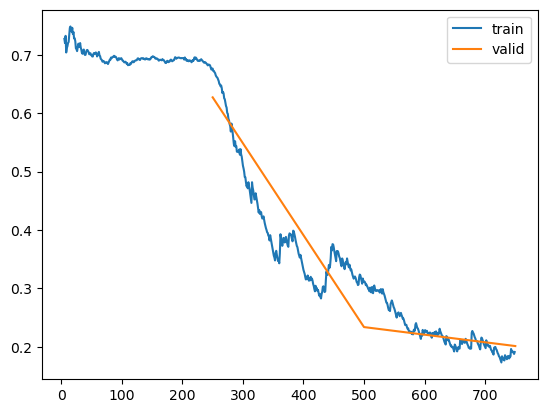

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"This is a great film in many different ways...perhaps the most important is that it introduces Western audiences to the remarkable, tragic story of Aung San Suu Kyi and her fight for freedom and democracy. Wonderful acting, gorgeous cinematography, breathtaking action and suspense: ""Beyond Rangoon"" has everything. I've seen this movie several times over the last ten years and each time it means more to me. Not everyone will like it (hence the relatively low rating on IMDb), but that's because it",pos,pos
1,"As we are well aware, movies are not set out to be a direct incorporation of history, but it is a disgrace when a movie is made which has absolutely little to no correlation. I wish the director and/or the screen writer had done his/her research in this topic. All this movie does is create a forum for hate between people, while causing a rift that should not be there. This movie portrayed the Sikhs and Muslims in a very negative manor, while making the third group (Hindus) look as if they were n",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, type_tfms=[tfm, tfm2]),
    MultiCategoryBlock(encoded=True, vocab=civil_label_names),
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader(civil_label_names),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,I have just received $16546 This month working online. I am making a good home based income with just my Laptop vand only work for 3 to 4 hours a day. Everybody can Make this part time income from home. Just Visit This link for more info..----->> www.Nypost55.Com,[]
1,"Like this, stevenketola: ""Of course, the teachers are crucial. If they approach Shakespeare as something to be endured rather enjoyed... it's no fun for anyone."" Thank heavens I had teacher Brace Mousette for Grade 10 history/social studies. He was a true polymath guy (once termed ""Renaissance Man"")--most of his time was spent teaching shop courses. After school, he also taught us how to drive in a dual steering-wheel '54 Ford sedan--during which time he rolled his own and smoked 'em! Loved the",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"I am a humanitarian.. and without question a global supporter for the rights of Women and Children. In this regard, my initial response was; I am grateful that Canada was willing to help the millions of women in the USA.. who, without question, are b",[]
1,"Kyle Stromgren, You got a lot of opinions, none of which you have supported with facts.",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 377)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 377 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 377 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.001096478197723627, steep=0.02754228748381138, valley=9.120108734350652e-05, slide=0.0004786300996784121)

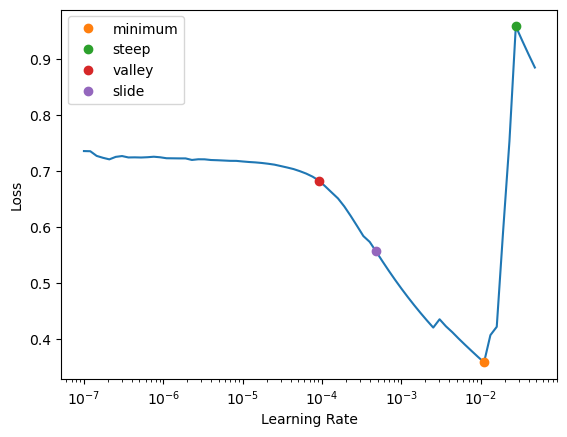

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07431776821613312
valid_loss 0.06935478746891022
accuracy_multi 0.9842856526374817


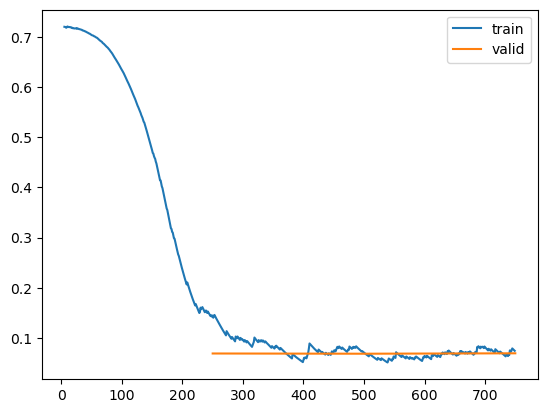

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"I am a humanitarian.. and without question a global supporter for the rights of Women and Children. In this regard, my initial response was; I am grateful that Canada was willing to help the millions of women in the USA.. who, without question, are being punitively treated, by their Government. Equally, on the other side, I do not want our Canadian Government to EVER, lose sight, of the VERI NECESSARY NEEDS, of Canadian Women, with respect, to effective, resource filled, women centers, and sexua",[],[]
1,"It appears that more NFL players are choosing to exhibit the ""Black Power"" salute. In the 1968 Summer Olympics, Americans Juan Carlos and Tommy Smith both raised the ""Black Power"" salute on the winners podium. The IOC stripped both of their medals and banned them from Olympic competition for life. The NFL players ""Black Power"" salute reflects what the African-American players fundamentally believe and espouse. However, DP and the Kiz both lack the moral ability to address what ""Black Power"" clea",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)
    item_tok_tfm = getattr(self.dls.dataset, "item_tokenize_transform", None)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None and item_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L212){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.8238478302955627,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.17615221440792084, 0.8238478302955627]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.804760754108429,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.19523923099040985, 0.804760754108429]},
 {'label': 0,
  'score': 0.5088809728622437,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5088809728622437, 0.49111899733543396]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 'neg',
  'score': 0.8070888519287109,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.8070888519287109, 0.19291113317012787]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 'pos',
  'score': 0.8111270666122437,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.18887288868427277, 0.8111270666122437]},
 {'label': 'neg',
  'score': 0.7034797668457031,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.7034797668457031, 0.29652026295661926]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.04107361659407616,
   0.0009969135280698538,
   0.004446460399776697,
   0.00180056260433048,
   0.031276408582925797,
   0.0012814830988645554,
   0.00151161290705204]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.04580241069197655, 0.03189048543572426],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.04580241069197655,
   0.0008953993674367666,
   0.003354940563440323,
   0.0021565433125942945,
   0.03189048543572426,
   0.0012846848694607615,
   0.0014719057362526655]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L285){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()